### 範例
接下來的程式碼會示範如何讀取 kaggle facial keypoint detection 資料集

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [164]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [165]:
# 如果要使用 kaggle API 下載資料的話，請用以下程式碼
# os.environ['KAGGLE_USERNAME'] = '____' # 請按照 Day42 簡報內容，獲取 kaggle api 需要用到的 username
# os.environ['KAGGLE_KEY'] = '____' # 請按照 Day42 簡報獲取 kaggle api 需要用到的 key
# !kaggle competitions download -c facial-keypoints-detection
# !unzip test.zip
# !unzip training.zip

### 資料前處理
資料分為兩部分，一個是關鍵點坐標，總共 15 個關鍵點，所以坐標相關的值有 15 x 2 = 30 維；
另外還有 96 x 96 的灰階像素值。

讀取資料後，先簡單地過濾有缺失某些關鍵點坐標的資料，然後再把資料 scale 到 [-0.5, 0.5] 的範圍

In [166]:
# 讀取 csv 文件
data = pd.read_csv("training/training.csv")

In [167]:
# .head() 預設顯示前 5 筆資料, .T 的作用是轉置，如果不理解可以和 data.head() 的結果相比較
# data.info()
data.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


In [168]:
data['Image'][0]    # nparray長度為9216 (96*96)
print(type(data["Image"][0]))
print(type(data["Image"]))

# test numpy
result = np.fromstring(data["Image"][0], sep=' ')
print(type(result))
print(result)

<class 'str'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
[238. 236. 237. ...  70.  75.  90.]


用 pandas 讀取 csv 文件後可以發現前 30 個 column 是坐標值，最後一個 column 是圖片像素值的字串 (以空白鍵區隔)，接下來我們就以下的函數來做資料的讀取以及前處理，請盡量仔細理解這個函數

In [169]:
# 過濾有缺失值的 row
data = data.dropna()    # drop NAN

# 將圖片像素值讀取為 numpy array 的形態
data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

# 單獨把圖像 array 抽取出來
imgs = np.vstack(data['Image'].values)/255
print(type(imgs))
print(imgs.shape)

# reshape 為 96 x 96
# imgs shape為 2410*96*96
imgs = imgs.reshape(data.shape[0], 96, 96)
print(data.shape[0])

# 轉換為 float
imgs = imgs.astype(np.float32)

# 提取坐標的部分
points = data[data.columns[:-1]].values
print(data[data.columns[:-1]])

# 轉換為 float
points = points.astype(np.float32)

# normalize 坐標值到 [-0.5, 0.5]
points = points/96 - 0.5

<class 'numpy.ndarray'>
(2140, 9216)
2140
      left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0             66.033564          39.002274           30.227008   
1             64.332936          34.970077           29.949277   
2             65.057053          34.909642           30.903789   
3             65.225739          37.261774           32.023096   
4             66.725301          39.621261           32.244810   
...                 ...                ...                 ...   
2277          67.180378          35.816373           33.239956   
2278          65.724490          36.301020           25.377551   
2281          68.430866          38.651975           28.895857   
2282          64.152180          30.691592           27.000898   
2283          66.683755          34.483429           30.784490   

      right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0              36.421678                59.582075                39.647423   
1        

In [170]:
print("圖像資料:", imgs.shape, "\n關鍵點資料:", points.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


### 作業
理解範例後請嘗試將關鍵點畫在圖像上，確保圖像及資料有正確讀取。
Hint: 可以用 [matplotlib 的 scatter](https://matplotlib.org/3.1.1/gallery/shapes_and_collections/scatter.html) 或者 [opencv 的 cv2.circle](https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html)

In [171]:
sample_img = imgs[0]
sample_points = points[0]

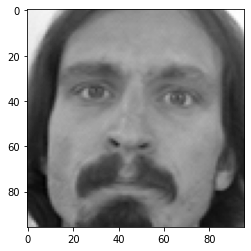

In [172]:
plt.imshow(sample_img, cmap='gray')